In [390]:
%load_ext autoreload
%autoreload 2

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

import os

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch

import renyi
import utils
import sxp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


$\newcommand{\X}{\mathcal{X}}$
$\newcommand{\k}{\kappa}$
$\newcommand{\D}{D^K_{\alpha}}$
$\newcommand{\H}{H^K_{\alpha}}$

## Similarity-sensitive entropy

Let $\mathcal{X}$ be a finite set of size $n$ and let $\k$ be a positive definite kernel. Let $X$ be a random variable with distribution $p$ on $\X$. Let $K$ be the Gram matrix induced by $\k$ on $\X$.

We define the similarity-sensitive Renyi entropy of order alpha [cite Tom Leinster] of $X$ by:

$$\H(p) = \frac{1}{1-\alpha} \log \sum_{i = 1}^n  p_i (Kp)_i^{\alpha-1}$$

Special Case: If we have a metric space $(\X, d)$, we can define $\k(x, y) \triangleq \exp(-d(x, y))$. [Reams]

## Performance test for entropy and divergence implementation

Can compute $H^K_{\alpha}(p)$ and $D^K_{\alpha}(p, q)$ :
  * $n= 1000$, $M = 100$ - H 4 ms D 13 ms
  * $n= 2000$, $M = 100$ - H 13 ms D 40 ms
  * $n= 10000$, $M = 100$ - H 263 ms D 865 ms
  * $n= 15000$, $M = 100$ - H 729 ms D 1760 ms
  
No significative variation in time when changing the order $\alpha$.

In [2]:
n, M = 100, 1000

%time K = 0.01*np.random.rand(n, n)
%time K = (K * K.T) + 0.7 * np.eye(n)
K = utils.from_numpy(K)

print('Min Eigenvalue of K: ', torch.eig(K)[0].min(dim=0)[0][0].item())

p = np.random.dirichlet(n*[1], M)
p = utils.from_numpy(p, True)

q = np.random.dirichlet(n*[1], M)
q = utils.from_numpy(q, True)

%time H = renyi.sim_entropy(K, p)
%time D = renyi.sim_divergence(K, p, q)

# for alpha in [0.1, 0.3, 0.5, 1, 1.5, 2]:
#     #W = renyi.sim_divergence(K, p, q, alpha)
#     W = renyi.sim_entropy(K, p, alpha)
#     plt.plot(W.data.numpy(), label=str(alpha));
# plt.legend(ncol=6, loc='best')

Wall time: 998 µs
Wall time: 0 ns
Min Eigenvalue of K:  0.699592180762266
Wall time: 3.99 ms
Wall time: 9.97 ms


## Similarity-sensitive divergence between two empirical distributions on a metric space

Let $(\X, \k)$ be a space endowed with a positive definite kernel. Consider two probability measures $\mu$ and $\nu$ defined on $\X$. Note that if an arbitrary $x \in \X$ has measure zero under both $\mu$ and $\nu$, then such $x$ is irrelevant in the computation of $\D(p || q)$.

Suppose $\mu$ and $\nu$ are empirical distributions of the form $\mu = \sum_{i = 1}^n a_i \delta_{x_i}$ and $\nu = \sum_{j = 1}^m b_i \delta_{y_i}$. Define the sequences $X = [x_1, \ldots, x_n ]$ and $Y = [y_1, \ldots, y_m]$. According to the remark above, we can restrict our attention to the sequence $Z = [X, Y] \triangleq [x_1, \ldots, x_n, y_1, \ldots, y_m ]$. The Gram matrix of $\k$ on $Z$ is a block matrix of the form: 

$$K \triangleq \begin{pmatrix} K_{xx} & K_{xy} \\  K_{yx} & K_{yy}  \end{pmatrix},$$

where $K_{xy}$ and $K_{yx}$ are possibly rectangular (and given $\k$ is p.d., $K_{xy} = K^T_{yx}$).

Define $\tilde{\mu}$ to be the natural extension of the vector representation of $\mu$ from $X$ to $Z$, i.e., $\tilde{\mu} = [\mu, 0]$. Analogously,  $\tilde{\nu} = [0, \nu]$. Let $\rho = \frac{\tilde{\mu} + \tilde{\nu}}{2}$.

$$\begin{eqnarray*} 
\D(\tilde{\mu}, \tilde{\nu}) &=& \frac{1}{\alpha - 1} \left[ \log \sum_{z \in Z} \tilde{\mu}_z \left( \frac{(K\tilde{\mu})_z}{(K\rho)_z}\right)^{\alpha-1} + \log \sum_{z \in Z} \tilde{\nu}_z \left( \frac{(K\tilde{\nu})_z}{(K\rho)_z}\right)^{\alpha-1} \right] \\ 
&=& \frac{1}{\alpha - 1} \left[ \log \sum_{x \in X} \mu_x \left( \frac{(K_{xx}\mu)_x}{\frac{1}{2}\left(K_{xx}\mu + K_{xy}\nu\right)_x}\right)^{\alpha-1} + \log \sum_{y \in Y} \nu_y \left( \frac{(K_{yy}\nu)_y}{\frac{1}{2}\left(K_{yy}\nu + K_{yx}\mu\right)_y}\right)^{\alpha-1} \right] \\
&=& \frac{1}{\alpha - 1} \left[ \log \left[ \mu^T \left( \frac{2 K_{xx}\mu}{K_{xx}\mu + K_{xy}\nu}\right)^{\alpha-1}\right] + \log \left[ \nu^T \left( \frac{2 K_{yy}\nu}{K_{yy}\nu + K_{yx}\mu}\right)^{\alpha-1} \right] \right] 
\end{eqnarray*}$$

The computation of $K$ requires $\mathcal{O}(|\k|(m+n)^2)$ operations, where $|\k|$ represents the cost of a kernel evaluation. The computation of the divergence (given $K$) is of in order of  $\mathcal{O}((n+m)^2)$ operations.

*Note:* We can do projected gradient descent on this objective using the sxp file. This gives sparse solutions on $\mu$, while the logit-softmax (with temperature) parametrization gives dense solutions. When $m >> n$, softmax is advisable, while projected gradient is to be preferred when $n >> m$


In [779]:
alpha = 2

m, d = 10, 2

nu = np.random.dirichlet(m*[m], 1)
nu = -np.sort(-nu, axis=1)
nu = torch.tensor(nu)
Y = torch.tensor(np.random.multivariate_normal(np.zeros(d), np.eye(d), m))

n = 50

#mu_free = torch.nn.Parameter(torch.tensor(1+0.*np.random.rand(1, n)))
# For projected gradient initialize with a sparse solution on simplex
mu_free = torch.nn.Parameter(torch.tensor(np.random.dirichlet(n*[1], 1)))

X = torch.nn.Parameter(torch.tensor(np.random.multivariate_normal(np.zeros(d), 1.1*np.eye(d), n)))
temp = torch.nn.Parameter(torch.tensor(1.).double())

mu_optimizer = torch.optim.Adam([mu_free, temp], lr=0.005, amsgrad=True)
x_optimizer = torch.optim.Adam([X], lr=0.1, amsgrad=True)
optims = [mu_optimizer, x_optimizer]

kernel = lambda x, y: renyi.generic_kernel(x, y, renyi.rbf_kernel)

0 - 0.0880


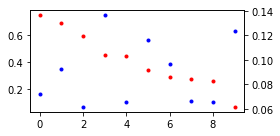

75 - 0.0013


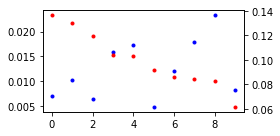

150 - 0.0019


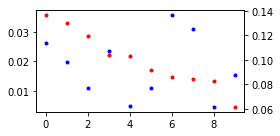

225 - 0.0017


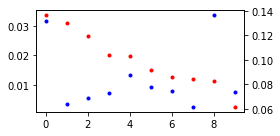

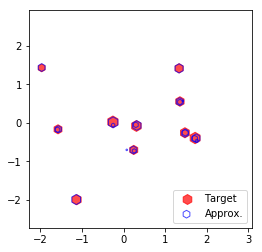

Sparsity of solution: 60.0% (20/50)


In [780]:
for _ in range(250):
    
    [_.zero_grad() for _ in optims]
    
    #mu = torch.softmax(mu_free / torch.exp(temp), dim=1)
    mu = sxp.simplex_project(mu_free)
    loss, K = renyi.mixture_divergence(mu, X, nu, Y, alpha, kernel)
    
    if _ % 75 == 0:
        print("%d - %.4f" % (_, loss.item()))
        
    if _ % 75 == 0:    
        W = torch.cat((X, Y))
        D = torch.norm(W[..., None, :] - W[..., None, :, :], p=2, dim=-1) 
    
        fig, ax1 = plt.subplots(figsize=(4, 2))
        ax1.plot(D[-m:, :n].min(dim=1)[0].data.numpy(), 'b.')
        ax1.twinx().plot(nu[0, :].data.numpy(), 'r.')
        fig.tight_layout()
        plt.show()
        
#         plt.figure(figsize=(4, 4))
#         plt.scatter(Y.data.numpy()[:, 0], Y.data.numpy()[:, 1], s=list(1000*nu.data.squeeze().numpy()), label='Target', marker='h', c='r', alpha=0.7)
#         plt.scatter(X.data.numpy()[:, 0], X.data.numpy()[:, 1], s=list(1000*mu.data.squeeze().numpy()), label='Approx.', marker='h', facecolors='none', edgecolors='b', alpha=0.7)
#         plt.legend(loc='best');
#         plt.show()

    loss.backward()
    [_.step() for _ in optims]
    
mu = sxp.simplex_project(mu_free) 
#mu = torch.softmax(mu_free / torch.exp(temp), dim=1)
    
plt.figure(figsize=(4, 4))
plt.scatter(Y.data.numpy()[:, 0], Y.data.numpy()[:, 1], s=list(1000*nu.data.squeeze().numpy()), label='Target', marker='h', c='r', alpha=0.7)
plt.scatter(X.data.numpy()[:, 0], X.data.numpy()[:, 1], s=list(1000*mu.data.squeeze().numpy()), label='Approx.', marker='h', facecolors='none', edgecolors='b', alpha=0.7)
plt.legend(loc='best')
plt.show();

print('Sparsity of solution: %.1f%% (%d/%d)' % (100 * (1 - torch.sum(mu > 0).item() / n), torch.sum(mu > 0).item(), n))